In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import joblib

In [2]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("Dataset shape:", X.shape)
print("Target classes:", np.unique(y))

Dataset shape: (569, 30)
Target classes: [0 1]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

Train size: (455, 30)
Test size : (114, 30)


In [4]:
# Base learners (3 different types)
base_models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000))
    ]),

    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),

    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(probability=True, kernel="rbf"))
    ])
}

# Meta learner (final model)
meta_model = LogisticRegression(max_iter=2000)


In [5]:
results = []

for name, model in base_models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    results.append([name, acc, f1])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
results_df


,Model,Accuracy,F1 Score
0,Logistic Regression,0.982456,0.986111
1,Random Forest,0.947368,0.958333
2,SVM,0.982456,0.986111


In [6]:
results = []

for name, model in base_models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    results.append([name, acc, f1])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
results_df


,Model,Accuracy,F1 Score
0,Logistic Regression,0.982456,0.986111
1,Random Forest,0.947368,0.958333
2,SVM,0.982456,0.986111


In [7]:
def stacking_predictions(base_models, meta_model, X_train, y_train, X_test, folds=5):

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    # store meta features
    meta_X_train = np.zeros((X_train.shape[0], len(base_models)))
    meta_X_test = np.zeros((X_test.shape[0], len(base_models)))

    for model_index, (name, model) in enumerate(base_models.items()):
        print(f"Training base model: {name}")

        oof_pred = np.zeros(X_train.shape[0])
        test_pred_each_fold = np.zeros((X_test.shape[0], folds))

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # clone model so each fold uses fresh model
            m = clone(model)
            m.fit(X_tr, y_tr)

            # OOF prediction on validation set
            oof_pred[val_idx] = m.predict_proba(X_val)[:, 1]

            # prediction on test set
            test_pred_each_fold[:, fold] = m.predict_proba(X_test)[:, 1]

        # save OOF and averaged test predictions as meta-features
        meta_X_train[:, model_index] = oof_pred
        meta_X_test[:, model_index] = test_pred_each_fold.mean(axis=1)

    # Train meta model using meta features
    meta_model.fit(meta_X_train, y_train)

    # final prediction
    final_pred = meta_model.predict(meta_X_test)

    return final_pred, meta_X_train, meta_X_test


In [8]:
stack_pred, meta_train, meta_test = stacking_predictions(
    base_models, meta_model,
    X_train, y_train,
    X_test,
    folds=5
)

stack_acc = accuracy_score(y_test, stack_pred)
stack_f1 = f1_score(y_test, stack_pred)

print("Stacking Accuracy:", stack_acc)
print("Stacking F1 Score :", stack_f1)


Training base model: Logistic Regression
Training base model: Random Forest
Training base model: SVM
Stacking Accuracy: 0.9736842105263158
Stacking F1 Score : 0.9790209790209791


In [9]:
results_df.loc[len(results_df)] = ["Stacking Ensemble", stack_acc, stack_f1]
results_df = results_df.sort_values(by="Accuracy", ascending=False)
results_df


,Model,Accuracy,F1 Score
0,Logistic Regression,0.982456,0.986111
2,SVM,0.982456,0.986111
3,Stacking Ensemble,0.973684,0.979021
1,Random Forest,0.947368,0.958333


Best Model: Logistic Regression


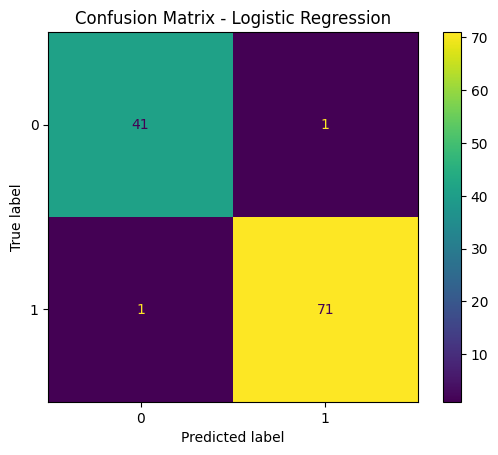

In [10]:
best_model_name = results_df.iloc[0]["Model"]
print("Best Model:", best_model_name)

# Use stacking predictions for confusion matrix if stacking is best
if best_model_name == "Stacking Ensemble":
    best_pred = stack_pred
else:
    # find the model again and predict
    for name, model in base_models.items():
        if name == best_model_name:
            model.fit(X_train, y_train)
            best_pred = model.predict(X_test)

cm = confusion_matrix(y_test, best_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


In [11]:
if best_model_name == "Stacking Ensemble":
    # Save stacking models
    model_to_save = {
        "base_models": base_models,
        "meta_model": meta_model
    }
    joblib.dump(model_to_save, "best_stacking_model.pkl")
    print("✅ Saved: best_stacking_model.pkl")

else:
    # Save single model
    for name, model in base_models.items():
        if name == best_model_name:
            model.fit(X_train, y_train)
            joblib.dump(model, "best_model.pkl")
            print("✅ Saved: best_model.pkl")

✅ Saved: best_model.pkl
